# ⚛️ H₂ Ground-State VQE — Noisy Simulation

This notebook studies **VQE under realistic noise** using your production-ready API:

- `run_vqe_optimizer_comparison`
- `run_vqe`

The goal is to understand how noise affects:

- Optimizer stability  
- Convergence  
- The final **noisy density matrix**  
- Basis-state populations  

Noise model (identical for all optimizers):
- **Depolarizing:** 10%  
- **Amplitude damping:** 10%  

These values are intentionally exaggerated to make behavioural differences clear.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from vqe.core import run_vqe_optimizer_comparison, run_vqe
from vqe_qpe_common.plotting import IMG_DIR

# Noise settings
depolarizing_prob = 0.10
amplitude_damping_prob = 0.10

seed = 0

# 🔧 Part 1 — Noisy Optimizer Comparison

We test three optimizers:

- **GradientDescent**
- **Adam**
- **Momentum**

using:

```python
run_vqe_optimizer_comparison(...)
```

This function:
✔ Builds the noisy device  
✔ Runs each optimizer  
✔ Applies both noise channels  
✔ Handles reproducibility + caching  
✔ Saves a convergence plot  
✔ Returns final energies  



⚙️ Running optimizer: Adam

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__TwoQubit-RY-CNOT__Adam__VQE__noisy__s0__62792b6d3c96.json

⚙️ Running optimizer: GradientDescent

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__TwoQubit-RY-CNOT__GradientDescent__VQE__noisy__s0__5a72a35ca1e1.json

⚙️ Running optimizer: Momentum

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__TwoQubit-RY-CNOT__Momentum__VQE__noisy__s0__d42cbb4da97f.json

⚙️ Running optimizer: Nesterov

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__TwoQubit-RY-CNOT__Nesterov__VQE__noisy__s0__d95f6c58e60b.json

⚙️ Running optimizer: RMSProp

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__TwoQubit-RY-CNOT__RMSProp__VQE__noisy__s0__237eff258770.json

⚙️ Running optimizer: Adagrad

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results

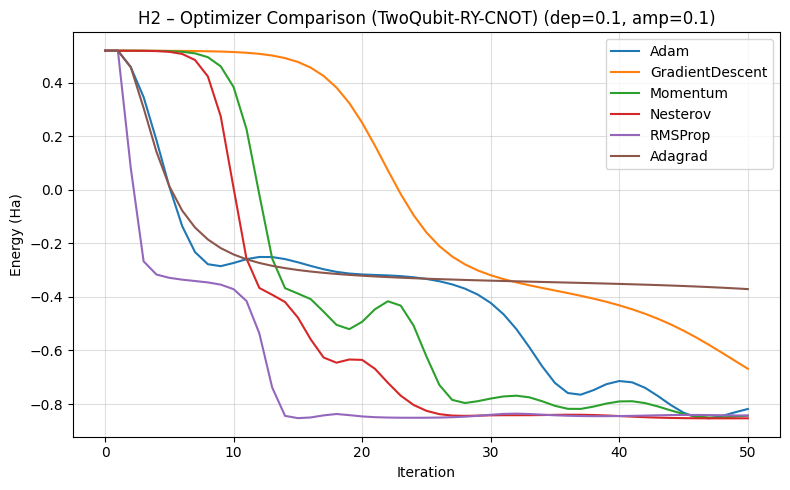

<Figure size 640x480 with 0 Axes>

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/H2_optimizer_comparison_ansTwoQubit-RY-CNOT_modeconvergence.png


{'mode': 'convergence',
 'energies': {'Adam': [0.5194119042839198,
   0.5194119042839198,
   0.4581514936036839,
   0.3463298890497062,
   0.1851060093300128,
   0.011687259549066964,
   -0.13552386071581124,
   -0.2326235380080793,
   -0.2778873803295749,
   -0.2850408717892599,
   -0.27327104928264484,
   -0.258929838666583,
   -0.2508061418105163,
   -0.2511421562724331,
   -0.25864190227396733,
   -0.2706304643680842,
   -0.28416824388932044,
   -0.2966697250890366,
   -0.3063720043389707,
   -0.3126653389985559,
   -0.31610023299247514,
   -0.3179719678600539,
   -0.3196973705978402,
   -0.32236073414832817,
   -0.3266126027727254,
   -0.3328395562951671,
   -0.3414457160756455,
   -0.3531391293753276,
   -0.369165664628504,
   -0.39143640018530956,
   -0.4224582966926888,
   -0.4648936310313227,
   -0.5204252879532063,
   -0.587595377902106,
   -0.6591358737606258,
   -0.7213333185282444,
   -0.7589078988321712,
   -0.7649867022995993,
   -0.747877614269342,
   -0.725742383593990

In [12]:
optimizers = ["Adam", "GradientDescent", "Momentum", "Nesterov", "RMSProp", "Adagrad"]

comparison = run_vqe_optimizer_comparison(
    molecule="H2",
    ansatz_name="TwoQubit-RY-CNOT",
    optimizers=optimizers,
    steps=50,
    stepsize=0.2,
    noisy=True,
    depolarizing_prob=depolarizing_prob,
    amplitude_damping_prob=amplitude_damping_prob,
    seed=seed,
    show=True,
    force=False,
)

comparison

# ⭐ Part 2 — Identify the Worst Optimizer

Noise flattens the loss landscape, so optimizers behave differently than in
the noiseless case.  

We define the *worst* optimizer as the one with the **highest final energy**.

In [13]:
worst_optimizer = max(
    comparison["final_energies"],
    key=comparison["final_energies"].get
)

print(f"🏆 Worst optimizer under noise: {worst_optimizer}")

🏆 Worst optimizer under noise: Adagrad


# 🔍 Part 3 — Full Noisy VQE Using the Worst Optimizer

We now run a complete noisy VQE with:

- Ansatz: **TwoQubit-RY-CNOT**  
- Optimizer: worst performer  
- Depolarizing: 10%  
- Amplitude damping: 10%  

`run_vqe(...)` returns energies, metadata, and the full **noisy density matrix**.

In [14]:
res = run_vqe(
    molecule="H2",
    ansatz_name="TwoQubit-RY-CNOT",
    optimizer_name=worst_optimizer,
    n_steps=50,
    stepsize=0.2,
    noisy=True,
    depolarizing_prob=depolarizing_prob,
    amplitude_damping_prob=amplitude_damping_prob,
    seed=seed,
    plot=False,
    force=False,
)

rho = np.array(res["final_state_real"]) + 1j * np.array(res["final_state_imag"])
diag = np.diag(rho)

diag


📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__TwoQubit-RY-CNOT__Adagrad__VQE__noisy__s0__38eb3d4c8136.json


array([0.09187289+0.j, 0.00624649+0.j, 0.04382749+0.j, 0.00297985+0.j,
       0.21638296+0.j, 0.01471199+0.j, 0.07820649+0.j, 0.0053173 +0.j,
       0.2724516 +0.j, 0.01852412+0.j, 0.15401861+0.j, 0.01047181+0.j,
       0.0559387 +0.j, 0.0038033 +0.j, 0.02363915+0.j, 0.00160724+0.j])

# 🧮 Part 4 — Approximate Ket Representation  

For mixed states, the diagonal entries of ρ correspond to **basis-state
populations**.

We display only those above a small threshold.

In [15]:
threshold = 1e-2
num_wires = int(np.log2(len(diag)))

terms = [
    f"({amp:.4f}|{idx:0{num_wires}b}⟩)"
    for idx, amp in enumerate(diag)
    if abs(amp) > threshold
]

ket_estimate = " + ".join(terms)

print("Approximate noisy state:")
print(f"|ψ⟩ ≈ {ket_estimate}")

Approximate noisy state:
|ψ⟩ ≈ (0.0919+0.0000j|0000⟩) + (0.0438+0.0000j|0010⟩) + (0.2164+0.0000j|0100⟩) + (0.0147+0.0000j|0101⟩) + (0.0782+0.0000j|0110⟩) + (0.2725+0.0000j|1000⟩) + (0.0185+0.0000j|1001⟩) + (0.1540+0.0000j|1010⟩) + (0.0105+0.0000j|1011⟩) + (0.0559+0.0000j|1100⟩) + (0.0236+0.0000j|1110⟩)


# 📊 Part 5 — Basis-State Population Plot

The bar plot below visualizes **which computational states survive** after noise.

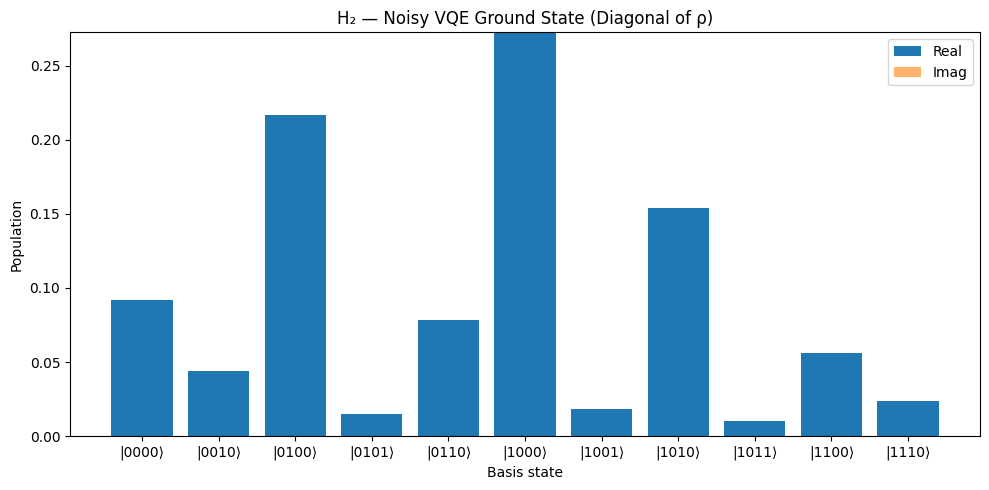

In [16]:
indices = np.where(abs(diag) > threshold)[0]
vals = diag[indices]
labels = [f"|{i:0{num_wires}b}⟩" for i in indices]

plt.figure(figsize=(10, 5))
plt.bar(labels, vals.real, label="Real")
plt.bar(labels, vals.imag, bottom=vals.real, alpha=0.6, label="Imag")

plt.xlabel("Basis state")
plt.ylabel("Population")
plt.title("H₂ — Noisy VQE Ground State (Diagonal of ρ)")
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(IMG_DIR, "H2_Noisy_Ground_State.png"), dpi=300)
plt.show()